In [1]:
# -*- coding: utf-8 -*-
"""Philosophy Text Classification - Most Stable Solution"""

# ======================
# 1. Environment Setup
# ======================
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

# Install required packages
!pip install -q --upgrade pip
!pip install -q \
    transformers==4.41.2 \
    tensorflow==2.16.1 \
    tensorflow-text==2.16.1 \
    datasets==2.19.1 \
    scikit-learn==1.4.2 \
    pandas==2.2.2 \
    numpy==1.26.4 \
    protobuf==3.20.3

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# ======================
# 2. Data Preparation
# ======================
print("Loading and preprocessing data...")
df = pd.read_csv('/kaggle/input/history-of-philosophy/philosophy_data.csv')

# Create balanced subset
total_samples = 10000
school_counts = df['school'].value_counts()
sample_per_school = (school_counts.astype(float) / len(df)) * total_samples
sample_per_school = sample_per_school.round().astype(int)

# Adjust count
difference = total_samples - sample_per_school.sum()
if difference != 0:
    sample_per_school.iloc[0] += difference

balanced_samples = []
for school, count in sample_per_school.items():
    school_samples = df[df['school'] == school].sample(count, random_state=42)
    balanced_samples.append(school_samples)

balanced_df = pd.concat(balanced_samples).sample(frac=1, random_state=42)

# Preprocess text
balanced_df['sentence_str'] = balanced_df['sentence_str'].astype(str).str.strip()
texts = balanced_df['sentence_str'].values
labels, class_names = pd.factorize(balanced_df['school'])
num_classes = len(class_names)

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = {i: float(w) for i, w in enumerate(class_weights)}

# ======================
# 3. Initialize Accelerator (TPU/GPU/CPU)
# ======================
print("\nInitializing hardware accelerator...")
try:
    # Attempt TPU initialization
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print('✅ TPU initialized')
except ValueError:
    # Fallback to GPU if available
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        strategy = tf.distribute.MirroredStrategy()
        print('✅ Using GPU')
    else:
        strategy = tf.distribute.get_strategy()
        print('⚠️ Using CPU')

print(f"Number of replicas: {strategy.num_replicas_in_sync}")

# ======================
# 4. Tokenization
# ======================
print("\nTokenizing data...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize(texts):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors="tf"
    )

train_encodings = tokenize(X_train)
val_encodings = tokenize(X_val)

# Create datasets
batch_size = 8 * strategy.num_replicas_in_sync  # Reduced from 16 to 8 for stability

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# ======================
# 5. Model Building
# ======================
print("\nBuilding model...")
tf.keras.backend.clear_session()

with strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=num_classes,
        from_pt=False  # Use TensorFlow weights
    )
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(3e-5),  # Slightly lower learning rate
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

print("\n🧠 Model Summary:")
try:
    model.summary()
except:
    print("Couldn't display full summary - continuing with training")

# ======================
# 6. Training
# ======================
print("\n🚀 Starting training...")
try:
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=3,
        class_weight=class_weights
    )
    print("\n✅ Training complete!")
except Exception as e:
    print(f"\n⚠️ Training interrupted: {str(e)}")
    print("Try reducing batch size or sequence length if this persists")

# ======================
# 7. Save Model
# ======================
try:
    model.save_pretrained('/kaggle/working/philosophy_classifier')
    tokenizer.save_pretrained('/kaggle/working/philosophy_classifier')
    print("\n💾 Model saved successfully")
except:
    print("\n⚠️ Could not save model - check available storage")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-tpu 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.3.2 which is incompatible.
tensorflow-tpu 2.18.0 requires tensorboard<2.19,>=2.18, but you have tensorboard 2.16.2 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.16.1 which is incompatible.
Loading and preprocessing data...

Initializing hardware accelerator...
⚠️ Using CPU
Number of replicas: 1

Tokenizing data...

Building model...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 


🧠 Model Summary:
Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  9997      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66963469 (255.45 MB)
Trainable params: 66963469 (255.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

🚀 Starting training...
Epoc


Making predictions...
250/250 [==============================] - 59s 220ms/step

Classification Report:
                 precision    recall  f1-score   support

  phenomenology       0.56      0.49      0.53       158
          plato       0.70      0.69      0.69       213
      aristotle       0.70      0.69      0.69       270
       analytic       0.70      0.71      0.70       308
    continental       0.53      0.66      0.59       187
     empiricism       0.62      0.60      0.61       110
german_idealism       0.67      0.65      0.66       234
       stoicism       0.78      0.50      0.61        14
    rationalism       0.55      0.38      0.45       127
       feminism       0.76      0.63      0.69       103
      nietzsche       0.46      0.60      0.52        75
      communism       0.67      0.72      0.70       100
     capitalism       0.80      0.90      0.85       101

       accuracy                           0.65      2000
      macro avg       0.65      0.63  

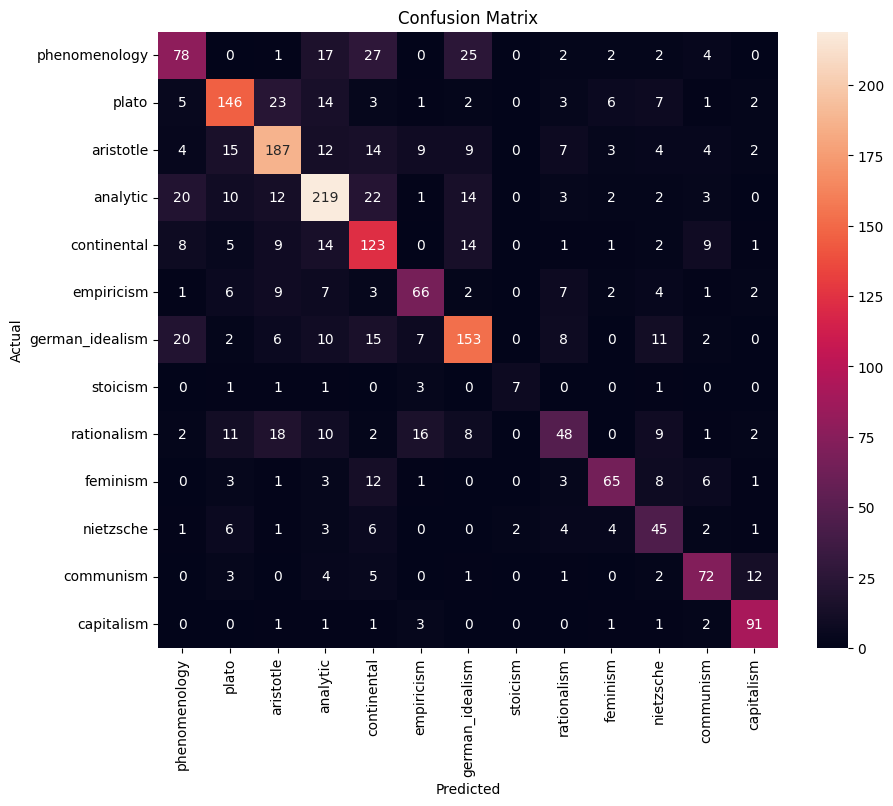


Sample Predictions:

Text: Suppose, to vary the example about Godcl, no one had discovered the incompleteness of arithmctic per...
Actual: analytic
Predicted: analytic
Confidence: 52.56%

Text: Whenever a relation holds between two or more terms, it unites the terms into a complex whole....
Actual: analytic
Predicted: german_idealism
Confidence: 76.41%

Text: And there are very many other virtues, so that one is not at a loss to say what virtue is....
Actual: plato
Predicted: aristotle
Confidence: 62.26%

Text: even if one secures these things unjustly, you call it virtue none the less?...
Actual: plato
Predicted: plato
Confidence: 97.59%

Text: But you still want to call the movement one of 'guiding'....
Actual: analytic
Predicted: analytic
Confidence: 48.73%


In [2]:
# ======================
# Prediction & Evaluation
# ======================
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Make predictions on validation set
print("\nMaking predictions...")
predictions = model.predict(val_dataset)
predicted_classes = np.argmax(predictions.logits, axis=1)

# 2. Classification report
print("\nClassification Report:")
print(classification_report(y_val, predicted_classes, target_names=class_names))

# 3. Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_val, predicted_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 4. Sample predictions
print("\nSample Predictions:")
sample_texts = X_val[:5]  # First 5 validation samples
for i, text in enumerate(sample_texts):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True)
    outputs = model(**inputs)
    predicted_idx = tf.argmax(outputs.logits, axis=1).numpy()[0]
    print(f"\nText: {text[:100]}...")
    print(f"Actual: {class_names[y_val[i]]}")
    print(f"Predicted: {class_names[predicted_idx]}")
    print(f"Confidence: {tf.nn.softmax(outputs.logits)[0][predicted_idx].numpy():.2%}")

In [6]:
def predict_text(model, tokenizer, text):
    # Tokenize input
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True)
    
    # Get prediction
    prediction = model.predict(dict(inputs))
    
    # Get predicted class and confidence
    predicted_class = np.argmax(prediction.logits[0])
    confidence = tf.nn.softmax(prediction.logits)[0][predicted_class].numpy()
    
    return predicted_class, confidence

# Example usage:
text = "Whenever a relation holds between two or more terms, it unites the terms into a complex whole"
class_idx, confidence = predict_text(model, tokenizer, text)

print(f"Predicted class: {class_names[class_idx]}")
print(f"Confidence: {confidence:.2%}")

1/1 [==============================] - 0s 49ms/step
Predicted class: german_idealism
Confidence: 82.13%


In [1]:
# -*- coding: utf-8 -*-
"""Philosophy Text Classification - Most Stable Solution"""

# ======================
# 1. Environment Setup
# ======================
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

# Install required packages
!pip install -q --upgrade pip
!pip install -q \
    transformers==4.41.2 \
    tensorflow==2.16.1 \
    tensorflow-text==2.16.1 \
    datasets==2.19.1 \
    scikit-learn==1.4.2 \
    pandas==2.2.2 \
    numpy==1.26.4 \
    protobuf==3.20.3

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# ======================
# 2. Data Preparation
# ======================
print("Loading and preprocessing data...")
df = pd.read_csv('/kaggle/input/history-of-philosophy/philosophy_data.csv')

# Create balanced subset
total_samples = 10000
school_counts = df['school'].value_counts()
sample_per_school = (school_counts.astype(float) / len(df)) * total_samples
sample_per_school = sample_per_school.round().astype(int)

# Adjust count
difference = total_samples - sample_per_school.sum()
if difference != 0:
    sample_per_school.iloc[0] += difference

balanced_samples = []
for school, count in sample_per_school.items():
    school_samples = df[df['school'] == school].sample(count, random_state=42)
    balanced_samples.append(school_samples)

balanced_df = pd.concat(balanced_samples).sample(frac=1, random_state=42)

# Preprocess text
balanced_df['sentence_str'] = balanced_df['sentence_str'].astype(str).str.strip()
texts = balanced_df['sentence_str'].values
labels, class_names = pd.factorize(balanced_df['school'])
num_classes = len(class_names)

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = {i: float(w) for i, w in enumerate(class_weights)}

# ======================
# 3. Initialize Accelerator (TPU/GPU/CPU)
# ======================
print("\nInitializing hardware accelerator...")
try:
    # Attempt TPU initialization
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print('✅ TPU initialized')
except ValueError:
    # Fallback to GPU if available
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        strategy = tf.distribute.MirroredStrategy()
        print('✅ Using GPU')
    else:
        strategy = tf.distribute.get_strategy()
        print('⚠️ Using CPU')

print(f"Number of replicas: {strategy.num_replicas_in_sync}")

# ======================
# 4. Tokenization
# ======================
print("\nTokenizing data...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize(texts):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors="tf"
    )

train_encodings = tokenize(X_train)
val_encodings = tokenize(X_val)

# Create datasets
batch_size = 8 * strategy.num_replicas_in_sync  # Reduced from 16 to 8 for stability

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# ======================
# 5. Model Building
# ======================
print("\nBuilding model...")
tf.keras.backend.clear_session()

with strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=num_classes,
        from_pt=False  # Use TensorFlow weights
    )
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(3e-5),  # Slightly lower learning rate
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

print("\n🧠 Model Summary:")
try:
    model.summary()
except:
    print("Couldn't display full summary - continuing with training")

# ======================
# 6. Training
# ======================
print("\n🚀 Starting training...")
try:
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=3,
        class_weight=class_weights
    )
    print("\n✅ Training complete!")
except Exception as e:
    print(f"\n⚠️ Training interrupted: {str(e)}")
    print("Try reducing batch size or sequence length if this persists")

# ======================
# 7. Save Model
# ======================
try:
    model.save_pretrained('/kaggle/working/philosophy_classifier')
    tokenizer.save_pretrained('/kaggle/working/philosophy_classifier')
    print("\n💾 Model saved successfully")
except:
    print("\n⚠️ Could not save model - check available storage")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-tpu 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.3.2 which is incompatible.
tensorflow-tpu 2.18.0 requires tensorboard<2.19,>=2.18, but you have tensorboard 2.16.2 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.16.1 which is incompatible.
Loading and preprocessing data...

Initializing hardware accelerator...
⚠️ Using CPU
Number of replicas: 1

Tokenizing data...

Building model...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 


🧠 Model Summary:
Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  9997      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66963469 (255.45 MB)
Trainable params: 66963469 (255.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

🚀 Starting training...
Epoc


Making predictions...
250/250 [==============================] - 60s 224ms/step

Classification Report:
                 precision    recall  f1-score   support

  phenomenology       0.65      0.50      0.56       158
          plato       0.69      0.70      0.69       213
      aristotle       0.78      0.62      0.69       270
       analytic       0.61      0.77      0.68       308
    continental       0.59      0.56      0.57       187
     empiricism       0.69      0.66      0.68       110
german_idealism       0.64      0.69      0.66       234
       stoicism       0.67      0.57      0.62        14
    rationalism       0.47      0.51      0.49       127
       feminism       0.67      0.70      0.69       103
      nietzsche       0.68      0.53      0.60        75
      communism       0.67      0.80      0.73       100
     capitalism       0.91      0.78      0.84       101

       accuracy                           0.66      2000
      macro avg       0.67      0.65  

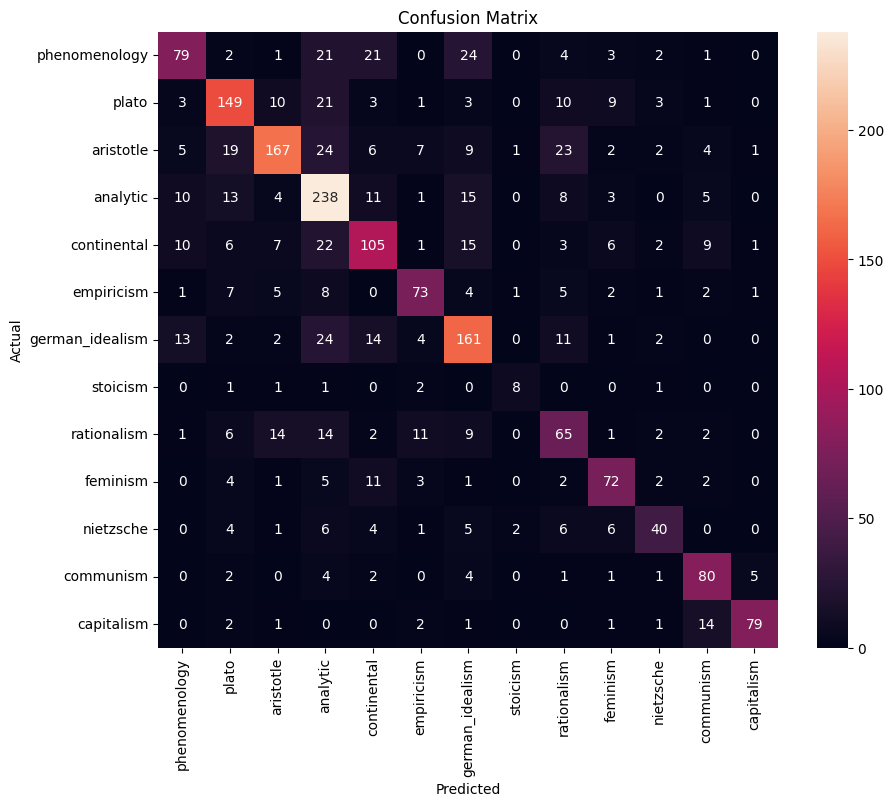


Sample Predictions:

Text: Suppose, to vary the example about Godcl, no one had discovered the incompleteness of arithmctic per...
Actual: analytic
Predicted: analytic
Confidence: 94.00%

Text: Whenever a relation holds between two or more terms, it unites the terms into a complex whole....
Actual: analytic
Predicted: analytic
Confidence: 70.46%

Text: And there are very many other virtues, so that one is not at a loss to say what virtue is....
Actual: plato
Predicted: rationalism
Confidence: 46.94%

Text: even if one secures these things unjustly, you call it virtue none the less?...
Actual: plato
Predicted: plato
Confidence: 96.31%

Text: But you still want to call the movement one of 'guiding'....
Actual: analytic
Predicted: analytic
Confidence: 67.16%


In [2]:
# ======================
# Prediction & Evaluation
# ======================
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Make predictions on validation set
print("\nMaking predictions...")
predictions = model.predict(val_dataset)
predicted_classes = np.argmax(predictions.logits, axis=1)

# 2. Classification report
print("\nClassification Report:")
print(classification_report(y_val, predicted_classes, target_names=class_names))

# 3. Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_val, predicted_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 4. Sample predictions
print("\nSample Predictions:")
sample_texts = X_val[:5]  # First 5 validation samples
for i, text in enumerate(sample_texts):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True)
    outputs = model(**inputs)
    predicted_idx = tf.argmax(outputs.logits, axis=1).numpy()[0]
    print(f"\nText: {text[:100]}...")
    print(f"Actual: {class_names[y_val[i]]}")
    print(f"Predicted: {class_names[predicted_idx]}")
    print(f"Confidence: {tf.nn.softmax(outputs.logits)[0][predicted_idx].numpy():.2%}")